#### 라이브러리 로드

In [80]:
import pandas as pd
from glob import glob
import os
pd.options.display.float_format = '{:.2f}'.format

#### 전처리 및 downcasting 함수 만들기

In [2]:
def preprocessing_(file):

    file_len = len(pd.read_csv(file, usecols=[0]).index)
    chunk_size = int(round((file_len / 50), 0))

    chunk = pd.read_csv(file, chunksize=chunk_size)
    chunk = list(chunk)

    lst = []
    for df in chunk:
        df = df.drop(columns=["user_session", 'category_id'])
        df = df.dropna()
        for col in df.columns:
            dtype_name = df[col].dtypes.name
            if dtype_name.startswith('int'):
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            elif dtype_name.startswith('float'):
                df[col] = pd.to_numeric(df[col],  downcast='float')
        lst.append(df)

    conc1 = pd.concat(lst[:25])
    conc2 = pd.concat(lst[25:])

    ecommerce_data = pd.concat([conc1, conc2]).reset_index(drop=True)

    return ecommerce_data

#### downcasting 전용 함수

In [3]:
def down_casting(data_set):
    for col in data_set.columns:
        dtype_name = data_set[col].dtypes.name
        if dtype_name.startswith('int'):
            data_set[col] = pd.to_numeric(data_set[col], downcast='unsigned')
        elif dtype_name.startswith('float'):
            data_set[col] = pd.to_numeric(data_set[col],  downcast='float')
    return data_set

#### 데이터 전처리 및 parquet 저장

##### 데이터 불러와 전처리

In [81]:
pd.read_csv(file_name[0], nrows = 50).head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [4]:
file_name = glob('data/2019*')
file_name

['data\\2019-Nov.csv', 'data\\2019-Oct.csv']

In [5]:
priority_dict = {'data\\2019-Oct.csv': 0, 'data\\2019-Nov.csv': 1}
file_name.sort(key=lambda x: priority_dict[x])
file_name

['data\\2019-Oct.csv', 'data\\2019-Nov.csv']

In [6]:
%%time
october = preprocessing_(file_name[0])
november = preprocessing_(file_name[1])

Wall time: 5min 49s


In [7]:
%%time
october.to_parquet('data/october.gzip', compression='gzip')
november.to_parquet('data/november.gzip', compression='gzip')

Wall time: 1min 50s


In [9]:
october_df = pd.read_parquet('data/october.gzip')
november_df = pd.read_parquet('data/november.gzip')

In [11]:
october_df.info()
november_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26560622 entries, 0 to 26560621
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_code  object 
 4   brand          object 
 5   price          float32
 6   user_id        int64  
dtypes: float32(1), int64(2), object(4)
memory usage: 1.3+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42089570 entries, 0 to 42089569
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_code  object 
 4   brand          object 
 5   price          float32
 6   user_id        int64  
dtypes: float32(1), int64(2), object(4)
memory usage: 2.0+ GB


In [10]:
display(october_df.head(2))
november_df.head(2)

,event_time,event_type,product_id,category_code,brand,price,user_id
0,2019-10-01 00:00:00 UTC,view,3900821,appliances.environment.water_heater,aqua,33.20,554748717
1,2019-10-01 00:00:01 UTC,view,1307067,computers.notebook,lenovo,251.74,550050854


,event_time,event_type,product_id,category_code,brand,price,user_id
0,2019-11-01 00:00:00 UTC,view,1003461,electronics.smartphone,xiaomi,489.07,520088904
1,2019-11-01 00:00:00 UTC,view,5000088,appliances.sewing_machine,janome,293.65,530496790


In [13]:
%%time
conc_octnov = pd.concat([october_df,november_df])

Wall time: 5.06 s


In [14]:
conc_octnov.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68650192 entries, 0 to 42089569
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_code  object 
 4   brand          object 
 5   price          float32
 6   user_id        int64  
dtypes: float32(1), int64(2), object(4)
memory usage: 3.8+ GB


In [15]:
%%time
conc_octnov.to_parquet('data/conc_octnov.gzip',compression='gzip')

Wall time: 2min 37s


In [82]:
pd.read_parquet('data/conc_octnov.gzip').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68650192 entries, 0 to 42089569
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_code  object 
 4   brand          object 
 5   price          float32
 6   user_id        int64  
dtypes: float32(1), int64(2), object(4)
memory usage: 3.8+ GB


In [2]:
%%time
octnov_df = pd.read_parquet('data/conc_octnov.gzip')

Wall time: 44 s


In [5]:
octnov_df = down_casting(octnov_df)

In [9]:
octnov_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68650192 entries, 0 to 42089569
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     uint32 
 3   category_code  object 
 4   brand          object 
 5   price          float32
 6   user_id        uint32 
dtypes: float32(1), object(4), uint32(2)
memory usage: 3.3+ GB


In [14]:
test = octnov_df.head(8)
test

,event_time,event_type,product_id,category_code,brand,price,user_id
0,2019-10-01 00:00:00 UTC,view,3900821,appliances.environment.water_heater,aqua,33.20,554748717
1,2019-10-01 00:00:01 UTC,view,1307067,computers.notebook,lenovo,251.74,550050854
2,2019-10-01 00:00:04 UTC,view,1004237,electronics.smartphone,apple,1081.98,535871217
3,2019-10-01 00:00:05 UTC,view,1480613,computers.desktop,pulser,908.62,512742880
4,2019-10-01 00:00:10 UTC,view,28719074,apparel.shoes.keds,baden,102.71,520571932
5,2019-10-01 00:00:11 UTC,view,1004545,electronics.smartphone,huawei,566.01,537918940
6,2019-10-01 00:00:11 UTC,view,2900536,appliances.kitchen.microwave,elenberg,51.46,555158050
7,2019-10-01 00:00:11 UTC,view,1005011,electronics.smartphone,samsung,900.64,530282093


In [7]:
def split_category(A):
    return A.split('.')[0]

In [ ]:
test['category_code'].map(split_category)

In [49]:
test['large_category'] = test['category_code'].map(split_category).copy()
test[test['large_category'].isin(['computers', 'electronics'])]

C:\Users\juku\AppData\Local\Temp\ipykernel_8108\880631087.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['large_category'] = test['category_code'].map(split_category).copy()


,event_time,event_type,product_id,category_code,brand,price,user_id,large_category
1,2019-10-01 00:00:01 UTC,view,1307067,computers.notebook,lenovo,251.74,550050854,computers
2,2019-10-01 00:00:04 UTC,view,1004237,electronics.smartphone,apple,1081.98,535871217,electronics
3,2019-10-01 00:00:05 UTC,view,1480613,computers.desktop,pulser,908.62,512742880,computers
5,2019-10-01 00:00:11 UTC,view,1004545,electronics.smartphone,huawei,566.01,537918940,electronics
7,2019-10-01 00:00:11 UTC,view,1005011,electronics.smartphone,samsung,900.64,530282093,electronics


In [8]:
%%time
octnov_df['large_category'] = octnov_df['category_code'].map(split_category).copy()

Wall time: 21.6 s


In [9]:
%%time
analysis_data = octnov_df[octnov_df['large_category'].isin(['computers', 'electronics'])]
analysis_data.head(8)

Wall time: 1min 13s


,event_time,event_type,product_id,category_code,brand,price,user_id,large_category
1,2019-10-01 00:00:01 UTC,view,1307067,computers.notebook,lenovo,251.74,550050854,computers
2,2019-10-01 00:00:04 UTC,view,1004237,electronics.smartphone,apple,1081.98,535871217,electronics
3,2019-10-01 00:00:05 UTC,view,1480613,computers.desktop,pulser,908.62,512742880,computers
5,2019-10-01 00:00:11 UTC,view,1004545,electronics.smartphone,huawei,566.01,537918940,electronics
7,2019-10-01 00:00:11 UTC,view,1005011,electronics.smartphone,samsung,900.64,530282093,electronics
10,2019-10-01 00:00:18 UTC,view,1801995,electronics.video.tv,haier,193.03,537192226,electronics
12,2019-10-01 00:00:19 UTC,view,1306631,computers.notebook,hp,580.89,550050854,computers
13,2019-10-01 00:00:19 UTC,view,1005135,electronics.smartphone,apple,1747.79,535871217,electronics


In [10]:
def split_small_category(B):
    return B.split('.')[-1]

In [11]:
%%time
analysis_data['small_category'] = analysis_data['category_code'].map(split_small_category).copy()

Wall time: 15.8 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [64]:
analysis_data.head()

,event_time,event_type,product_id,category_code,large_category,small_category,brand,price,user_id
1,2019-10-01 00:00:01 UTC,view,1307067,computers.notebook,computers,notebook,lenovo,251.74,550050854
2,2019-10-01 00:00:04 UTC,view,1004237,electronics.smartphone,electronics,smartphone,apple,1081.98,535871217
3,2019-10-01 00:00:05 UTC,view,1480613,computers.desktop,computers,desktop,pulser,908.62,512742880
5,2019-10-01 00:00:11 UTC,view,1004545,electronics.smartphone,electronics,smartphone,huawei,566.01,537918940
7,2019-10-01 00:00:11 UTC,view,1005011,electronics.smartphone,electronics,smartphone,samsung,900.64,530282093


In [12]:
%%time
analysis_data = analysis_data[['event_time', 'event_type', 'product_id', 'category_code', 'large_category', 'small_category', 'brand', 'price', 'user_id']]

Wall time: 2min 28s


In [77]:
analysis_data.head(2)

,event_time,event_type,product_id,category_code,large_category,small_category,brand,price,user_id
1,2019-10-01 00:00:01 UTC,view,1307067,computers.notebook,computers,notebook,lenovo,251.74,550050854
2,2019-10-01 00:00:04 UTC,view,1004237,electronics.smartphone,electronics,smartphone,apple,1081.98,535871217


In [13]:
%%time
analysis_data.to_parquet('data/analysis_data.gzip',compression='gzip')

Wall time: 2min 49s


In [14]:
pd.read_parquet('data/analysis_data.gzip').head()

,event_time,event_type,product_id,category_code,large_category,small_category,brand,price,user_id
1,2019-10-01 00:00:01 UTC,view,1307067,computers.notebook,computers,notebook,lenovo,251.74,550050854
2,2019-10-01 00:00:04 UTC,view,1004237,electronics.smartphone,electronics,smartphone,apple,1081.98,535871217
3,2019-10-01 00:00:05 UTC,view,1480613,computers.desktop,computers,desktop,pulser,908.62,512742880
5,2019-10-01 00:00:11 UTC,view,1004545,electronics.smartphone,electronics,smartphone,huawei,566.01,537918940
7,2019-10-01 00:00:11 UTC,view,1005011,electronics.smartphone,electronics,smartphone,samsung,900.64,530282093


In [15]:
%%time
analysis_data_2 = analysis_data.drop(columns=['category_code'])

Wall time: 38.3 s


In [16]:
analysis_data_2 = analysis_data_2.drop_duplicates()

In [17]:
%%time
analysis_data_2.to_parquet('data/analysis_data_2.gzip', compression = 'gzip')

Wall time: 2min 26s


##### 분석할 데이터 바로 불러오기

In [5]:
%%time
analysis_df = pd.read_parquet('data/analysis_data_2.gzip').reset_index(drop = True)
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45635900 entries, 0 to 45635899
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   event_time      object 
 1   event_type      object 
 2   product_id      int64  
 3   large_category  object 
 4   small_category  object 
 5   brand           object 
 6   price           float32
 7   user_id         int64  
dtypes: float32(1), int64(2), object(5)
memory usage: 2.6+ GB
Wall time: 17.1 s


#### 전처리한 데이터를 바탕으로 DAU/MAU 구하기

##### DAU 구하기

In [19]:
analysis_df.head()

,event_time,event_type,product_id,large_category,small_category,brand,price,user_id
0,2019-10-01 00:00:01 UTC,view,1307067,computers,notebook,lenovo,251.74,550050854
1,2019-10-01 00:00:04 UTC,view,1004237,electronics,smartphone,apple,1081.98,535871217
2,2019-10-01 00:00:05 UTC,view,1480613,computers,desktop,pulser,908.62,512742880
3,2019-10-01 00:00:11 UTC,view,1004545,electronics,smartphone,huawei,566.01,537918940
4,2019-10-01 00:00:11 UTC,view,1005011,electronics,smartphone,samsung,900.64,530282093


In [21]:
aa = analysis_df.head()
aa

,event_time,event_type,product_id,large_category,small_category,brand,price,user_id
0,2019-10-01 00:00:01 UTC,view,1307067,computers,notebook,lenovo,251.74,550050854
1,2019-10-01 00:00:04 UTC,view,1004237,electronics,smartphone,apple,1081.98,535871217
2,2019-10-01 00:00:05 UTC,view,1480613,computers,desktop,pulser,908.62,512742880
3,2019-10-01 00:00:11 UTC,view,1004545,electronics,smartphone,huawei,566.01,537918940
4,2019-10-01 00:00:11 UTC,view,1005011,electronics,smartphone,samsung,900.64,530282093


In [6]:
def leave_only_date(datetime):
    return datetime[:10]

In [7]:
def leave_only_YM(datetime):
    return datetime[:7]

In [34]:
aa['event_time'] = aa['event_time'].map(leave_only_date).copy()
aa

C:\Users\juku\AppData\Local\Temp\ipykernel_4412\4292155006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aa['event_time'] = aa['event_time'].map(leave_only_date).copy()


,event_time,event_type,product_id,large_category,small_category,brand,price,user_id
0,2019-10-01,view,1307067,computers,notebook,lenovo,251.74,550050854
1,2019-10-01,view,1004237,electronics,smartphone,apple,1081.98,535871217
2,2019-10-01,view,1480613,computers,desktop,pulser,908.62,512742880
3,2019-10-01,view,1004545,electronics,smartphone,huawei,566.01,537918940
4,2019-10-01,view,1005011,electronics,smartphone,samsung,900.64,530282093


In [8]:
%%time
analysis_df['event_time'] = analysis_df['event_time'].map(leave_only_date).copy()
analysis_df.head()

Wall time: 10.4 s


,event_time,event_type,product_id,large_category,small_category,brand,price,user_id
0,2019-10-01,view,1307067,computers,notebook,lenovo,251.74,550050854
1,2019-10-01,view,1004237,electronics,smartphone,apple,1081.98,535871217
2,2019-10-01,view,1480613,computers,desktop,pulser,908.62,512742880
3,2019-10-01,view,1004545,electronics,smartphone,huawei,566.01,537918940
4,2019-10-01,view,1005011,electronics,smartphone,samsung,900.64,530282093


In [10]:
%%time
analysis_df["event_time_YM"] = analysis_df['event_time'].map(leave_only_YM).copy()
analysis_df.head()

Wall time: 12 s


,event_time,event_type,product_id,large_category,small_category,brand,price,user_id,event_time_YM
0,2019-10-01,view,1307067,computers,notebook,lenovo,251.74,550050854,2019-10
1,2019-10-01,view,1004237,electronics,smartphone,apple,1081.98,535871217,2019-10
2,2019-10-01,view,1480613,computers,desktop,pulser,908.62,512742880,2019-10
3,2019-10-01,view,1004545,electronics,smartphone,huawei,566.01,537918940,2019-10
4,2019-10-01,view,1005011,electronics,smartphone,samsung,900.64,530282093,2019-10


In [7]:
# analysis_df["event_time"] = pd.to_datetime(analysis_df["event_time"])

In [11]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45635900 entries, 0 to 45635899
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   event_time      object 
 1   event_type      object 
 2   product_id      int64  
 3   large_category  object 
 4   small_category  object 
 5   brand           object 
 6   price           float32
 7   user_id         int64  
 8   event_time_YM   object 
dtypes: float32(1), int64(2), object(6)
memory usage: 2.9+ GB


##### (바로 불러오기) DAU MAU 구하기 위한 최종 전처리 데이터 

In [12]:
%%time
analysis_df.to_parquet('data/final_analysis_data.gzip', compression = 'gzip')

Wall time: 1min 25s


In [21]:
# %%time
# DAU = analysis_d.groupby('event_time').agg({'user_id': pd.Series.value_counts})f

In [22]:
%%time
for_dau_data = analysis_df[['event_time','user_id']].drop_duplicates()
DAU = for_dau_data.groupby('event_time').agg({'user_id':'count'})

Wall time: 46.9 s


In [24]:
DAU.head()

,user_id
event_time,
2019-10-01,100763
2019-10-02,99545
2019-10-03,95691
2019-10-04,114703
2019-10-05,102536


##### MAU 구하기

In [71]:
%%time
for_mau_data = analysis_df[['event_time_YM','user_id']].drop_duplicates()
MAU = for_mau_data.groupby('event_time_YM').agg({'user_id':'count'})

Wall time: 9.39 s


In [67]:
MAU

,user_id
event_time_YM,
2019-10,1782150
2019-11,2206500


In [75]:
MAU['Year-Month'] = MAU.index
MAU = MAU.rename(columns={'user_id':'Total_user_count'})
MAU = MAU.reset_index(drop = True)
MAU

,Total_user_count,Year-Month
0,1782150,2019-10
1,2206500,2019-11


#### DAU MAU 시각화

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

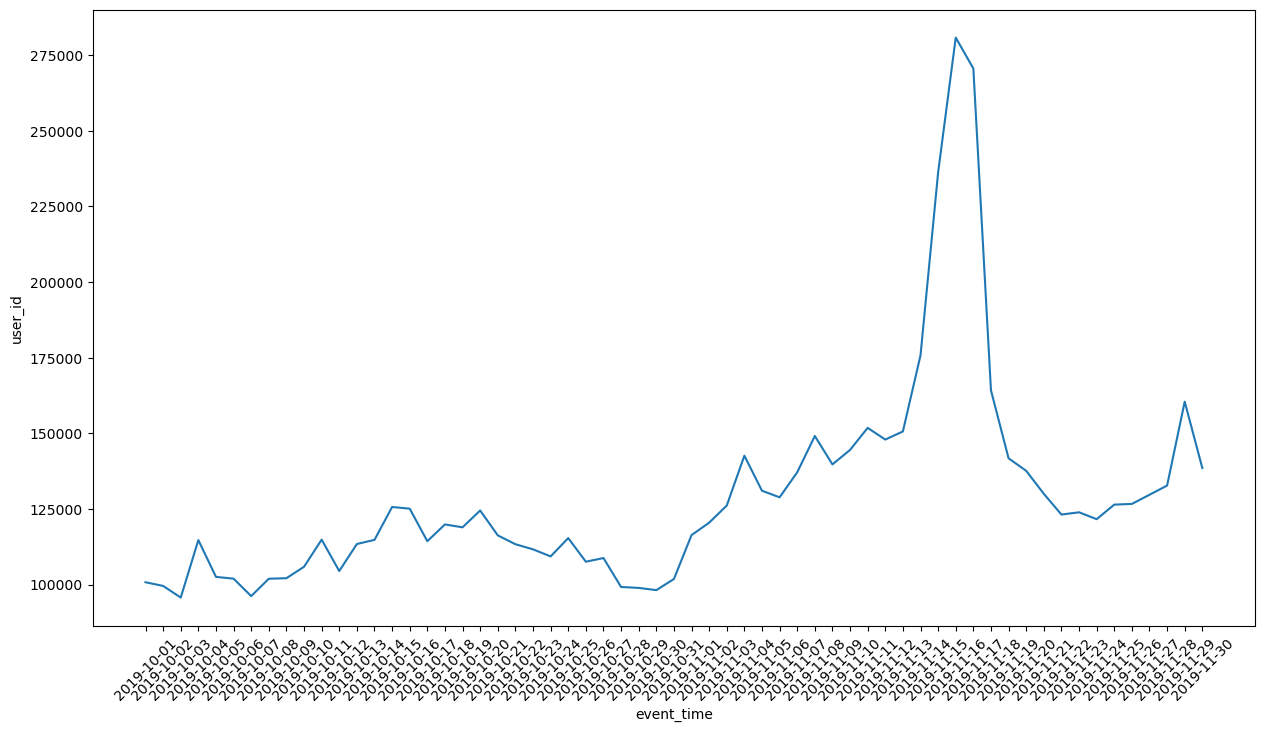

In [47]:
plt.figure(figsize = (15,8))
sns.lineplot(data = DAU, x = 'event_time', y = 'user_id')
plt.xticks(rotation = 45);

In [76]:
MAU

,Total_user_count,Year-Month
0,1782150,2019-10
1,2206500,2019-11


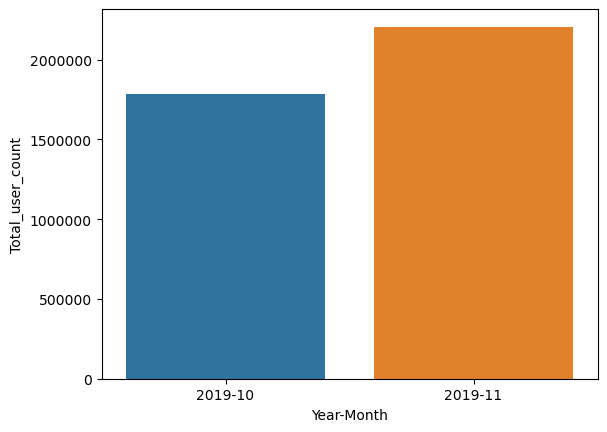

In [79]:
sns.barplot(data = MAU, x = 'Year-Month', y = 'Total_user_count')
plt.ticklabel_format(style='plain', axis='y');